In [35]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/026%20Anomaly%20Detection%20-%20Using%20Isolation%20Forests%20to%20fight%20Credit%20Card%20Fraud%20with%20Python.ipynb
#https://www.relataly.com/multivariate-outlier-detection-using-isolation-forests-in-python-detecting-credit-card-fraud/4233/
#http://localhost:8888/lab/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_confusion_matrix_concept.ipynb
#By https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#https://medium.com/@furry_furry/anomaly-detection-with-isolation-forest-45231e7c1e3f

# Step #1: Load the Data

In [3]:
# The Data can be downloaded from Kaggle.com: https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv
df = pd.read_csv('data/creditcard.csv')
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Step #2: Data Exploration

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_9400\3381217977.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_base = df.drop(['Time','Amount', 'Class'], 1)


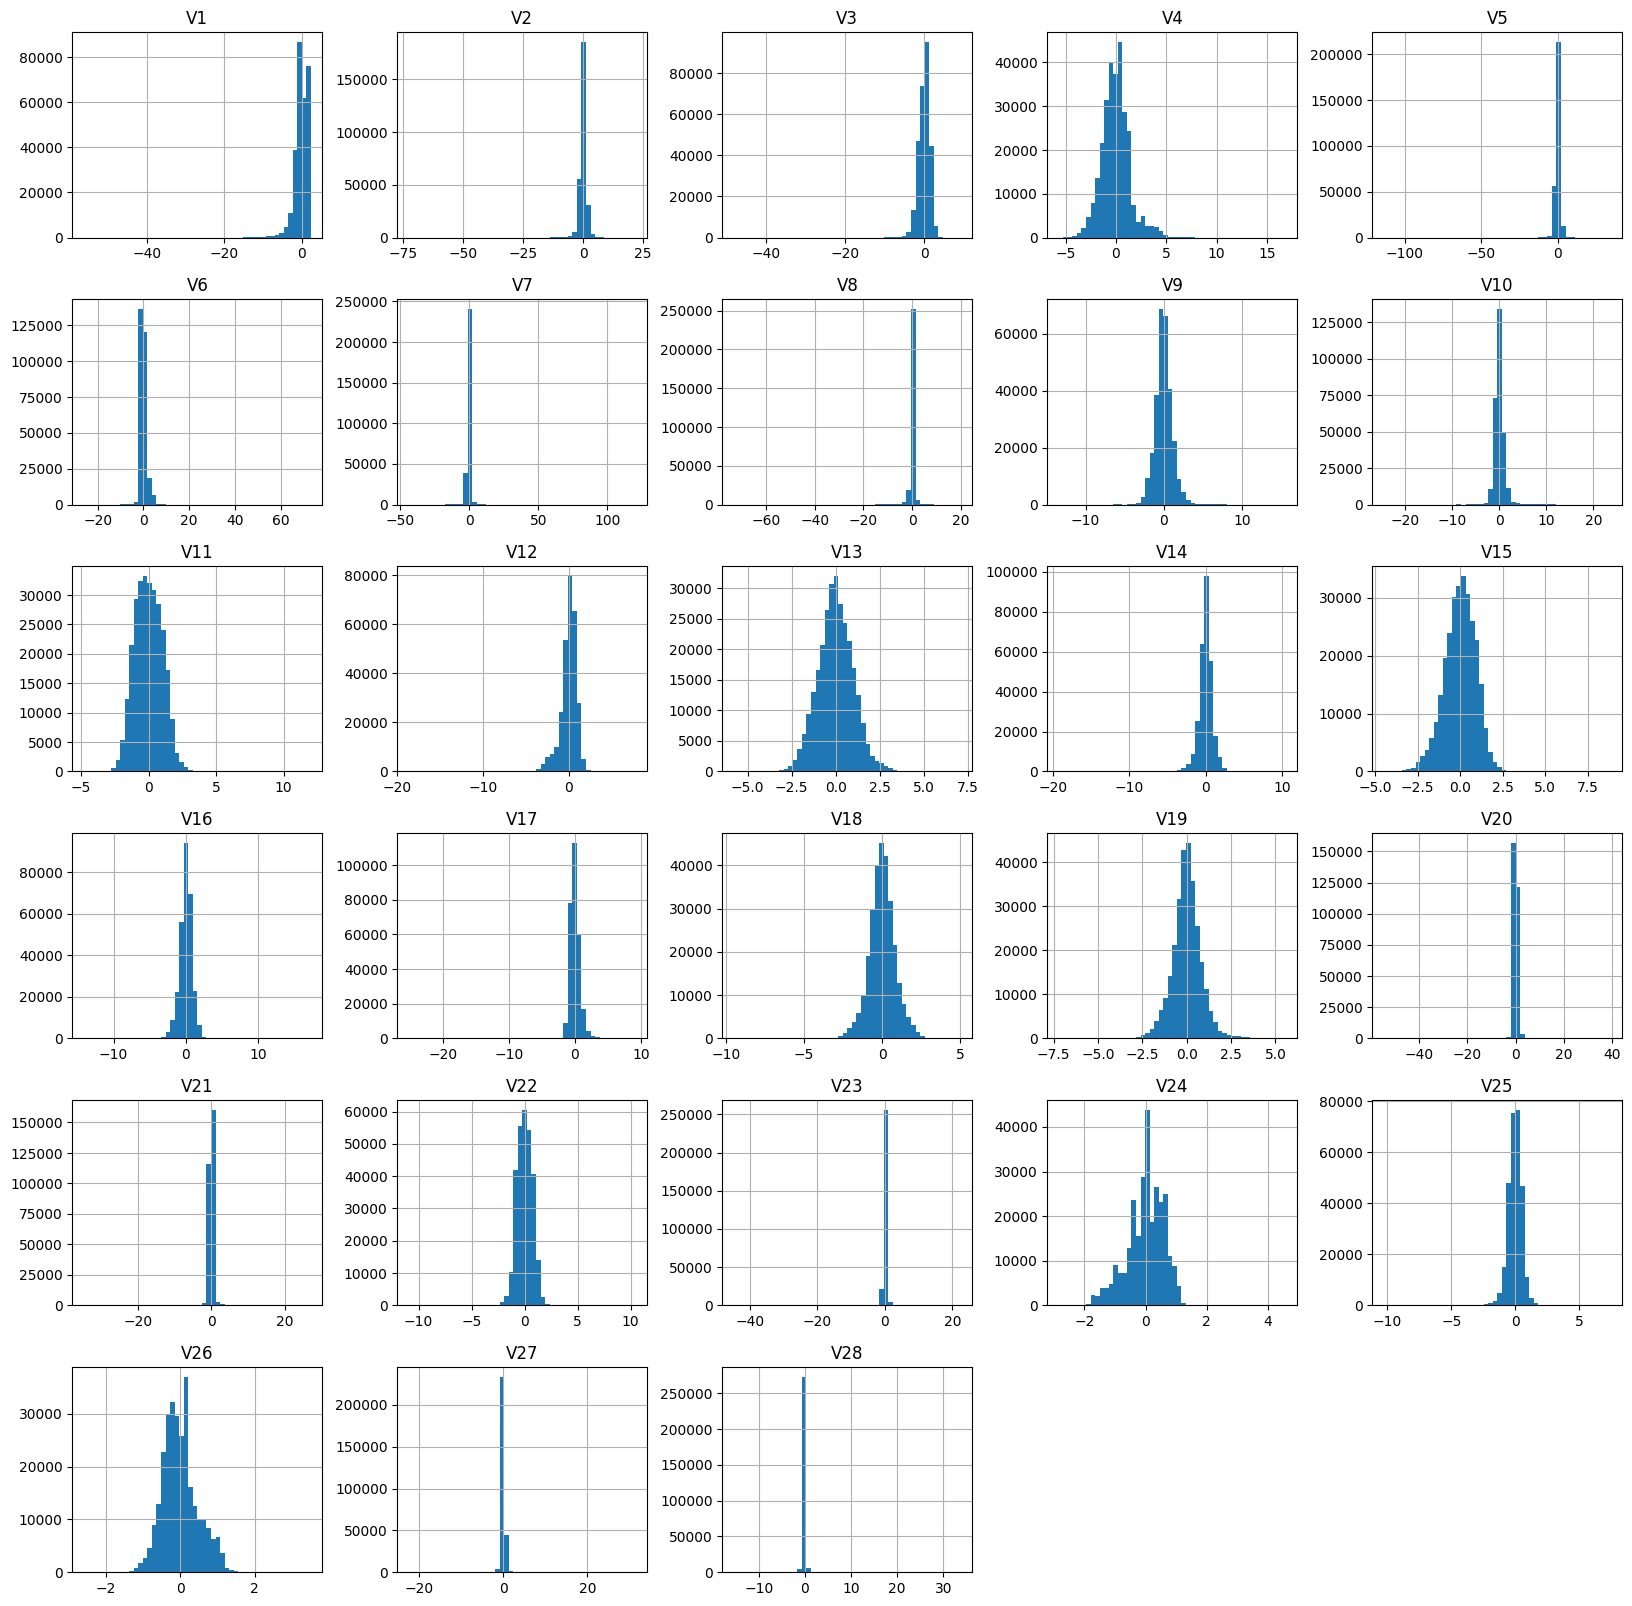

In [4]:
# create histograms on all features
df_base = df.drop(['Time','Amount', 'Class'], 1)
df_base.hist(figsize=(20,20), bins = 50)
plt.show()

<AxesSubplot: >

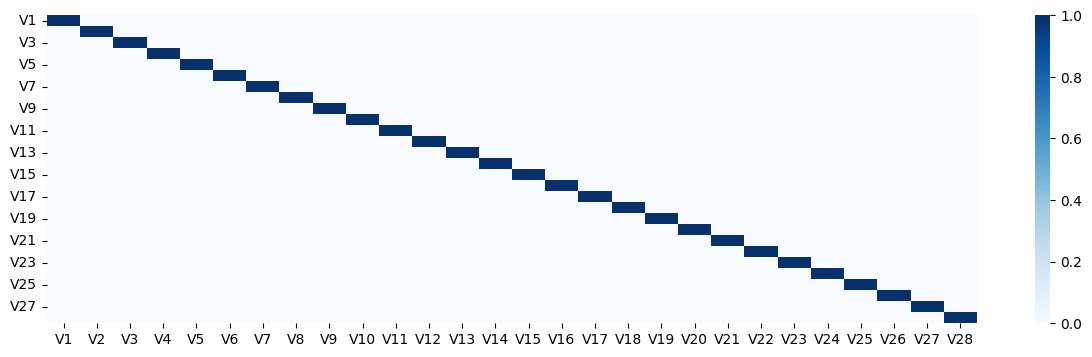

In [5]:
# Check that features are uncorrelated by making PCA
plt.figure(figsize=(15,4))
f_cor = df_base.corr()
sns.heatmap(f_cor, cmap="Blues")

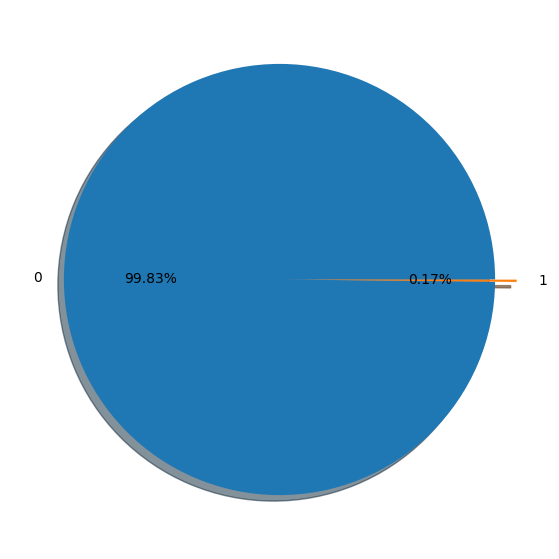

In [6]:
fig1, ax1 = plt.subplots(figsize=(14, 7))
plt.pie(df[['Class']].value_counts(), labels=[0,1], explode=[0,0.1], shadow=True,autopct='%1.2f%%')
plt.show()

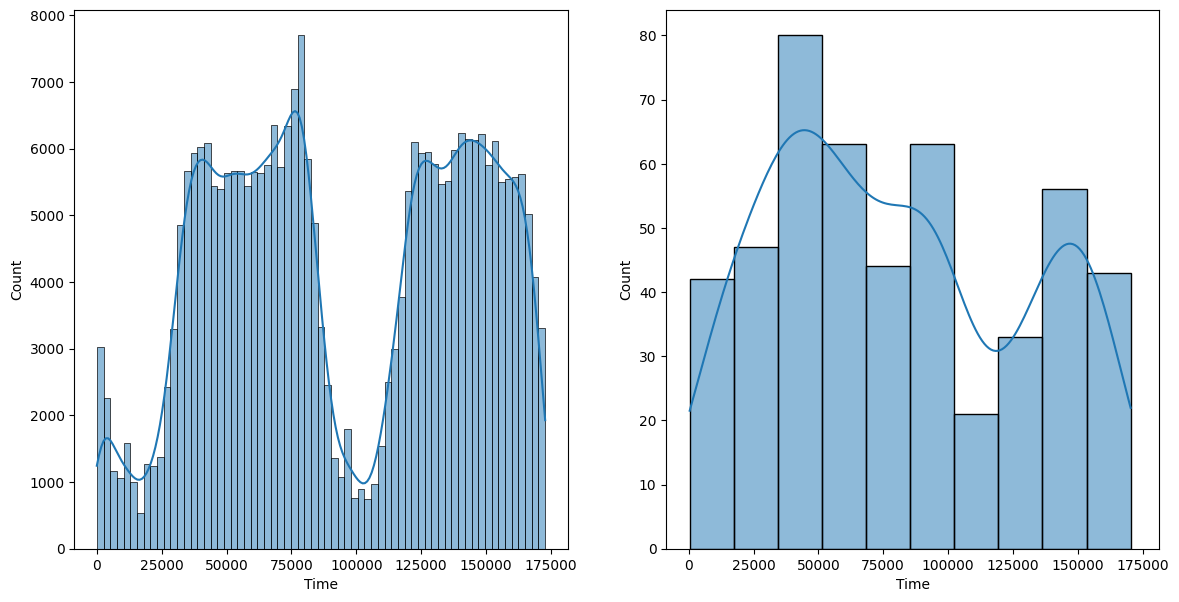

In [7]:
# Plot istribution of the Time variable, which contains transaction data for two days
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
sns.histplot(data=df[df['Class'] == 0], x='Time', kde=True, ax=ax[0])
sns.histplot(data=df[df['Class'] == 1], x='Time', kde=True, ax=ax[1])
plt.show()


Text(0.5, 0.98, 'Transaction Amount over Time split by Class')

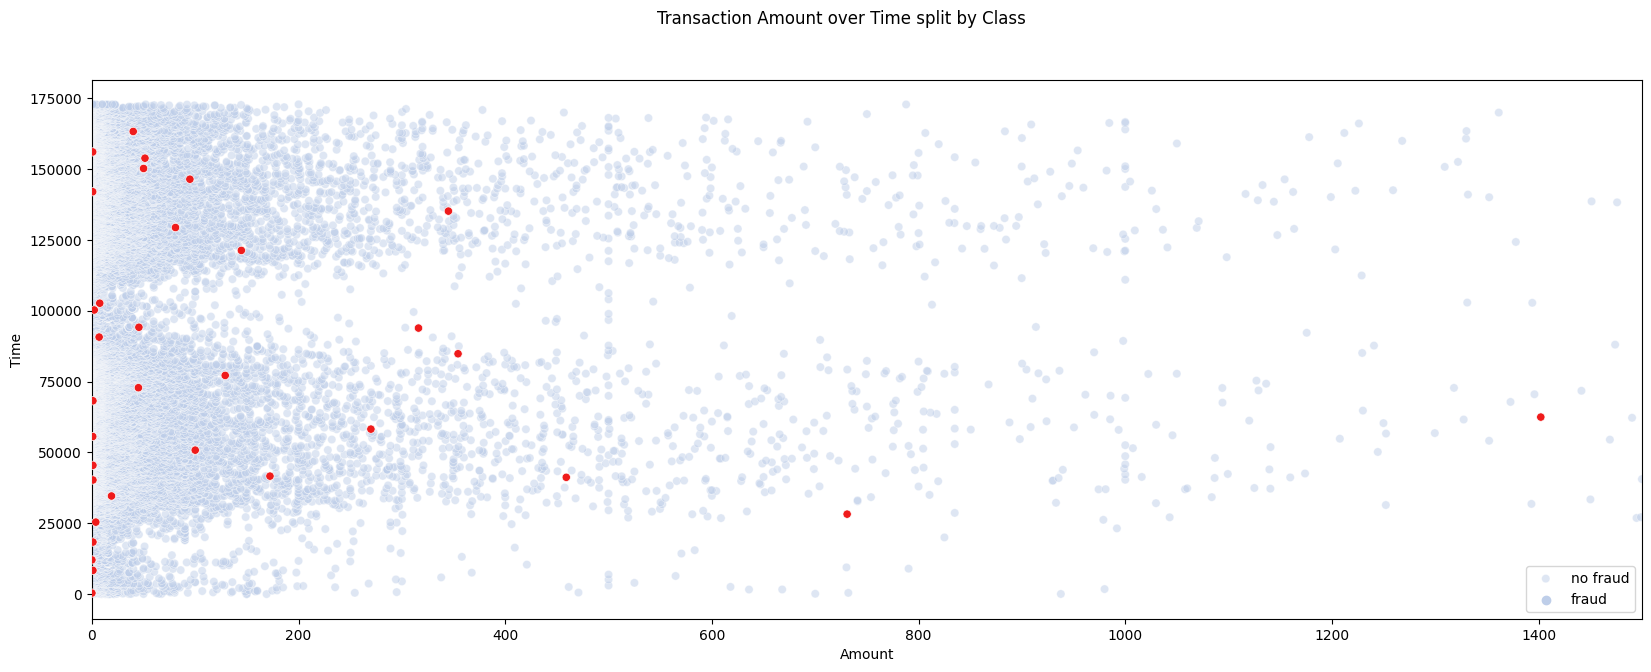

In [8]:
# Plot time against amount
fig, ax = plt.subplots(figsize=(20, 7))
ax.set(xlim=(0, 1500))
sns.scatterplot(data=df[df['Class']==0][::15], x='Amount', y='Time', hue="Class", palette=["#BECEE9"], alpha=.5, ax=ax)
sns.scatterplot(data=df[df['Class']==1][::15], x='Amount', y='Time', hue="Class", palette=["#EF1B1B"], zorder=100, ax=ax)
plt.legend(['no fraud', 'fraud'], loc='lower right')
fig.suptitle('Transaction Amount over Time split by Class')

# Step #3 Data Preprocessing

In [9]:
# Separate the classes from the train set
df_classes = df['Class']
df_train = df.drop(['Class'], axis=1)

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.30, random_state=42)
print(X_train.shape,X_test.shape)
print( y_train.shape, y_test.shape)

(199364, 30) (85443, 30)
(199364,) (85443,)


# Step #4 Train Models and Build Performance 

In [ ]:
# train the model on the nominal train set
model_isf = IsolationForest().fit(X_train)

In [ ]:
def build_measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    dfPred_test = X_test.copy()
    dfPred_test['Pred'] = model.predict(X_test)
    if map_labels:
        dfPred_test['Pred'] = dfPred_test['Pred'].map({1: 0, -1: 1})

    #y_true = dfPred_tes['Class']
    x_pred = dfPred_test['Pred'] 
    matrix = confusion_matrix(x_pred, y_true)
    dfmetrix=pd.DataFrame(matrix, columns = ['Actual', 'Predicted'])
    #print(dfmetrix)

    sns.heatmap(dfmetrix,
                xticklabels=['Noraml[0]', 'Fraud[1]'], 
                yticklabels=['Normal[0]', 'Fraud[1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

model_name = 'Isolation Forest (baseline)'
print(f'{model_name} model')

map_labels = True
model_score = build_measure_performance(model_isf, X_test, y_test, map_labels)
print(model_score)
performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)
performance_df 

# Tune IsolationForest

In [ ]:
n_estimators=[50, 100]
max_features=[1.0, 5, 10]
bootstrap=[True]
param_grid = dict(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)
contamination_rate = 'auto'  # 0.1(10%)-0.2(20%)

In [ ]:
# Build the gridsearch
model_isf = IsolationForest(contamination=contamination_rate, n_jobs=-1)
# model_isf = IsolationForest(n_estimators=n_estimators, 
#                             max_features=max_features, 
#                             contamination=contamination_rate, 
#                             bootstrap=False, 
#                             n_jobs=-1)


f1sc = make_scorer(f1_score, average='macro')
grid = GridSearchCV(estimator=model_isf, param_grid=param_grid, cv = 3, scoring=f1sc)
grid_results = grid.fit(X=X_train, y=y_train)
grid_results

In [ ]:
# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
# Evaluate model performance
model_name = 'Isolation Forest (tuned)'
print(f'{model_name} model')

best_model = grid_results.best_estimator_
best_model

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     81962
           1       0.79      0.03      0.06      3481

    accuracy                           0.96     85443
   macro avg       0.88      0.52      0.52     85443
weighted avg       0.95      0.96      0.94     85443

f1_score: 51.97%
'precision', 'recall', 'f-score'
[0.88, 0.52, 0.52]


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_9400\491353959.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = performance_df.append({'model_name':model_name,


,model_name,f1_score,precision,recall
0,Isolation Forest (baseline),0.901728,0.518367,0.526523
1,Isolation Forest (tuned),0.877289,0.515342,0.519693
2,Isolation Forest (tuned),0.877289,0.515342,0.519693


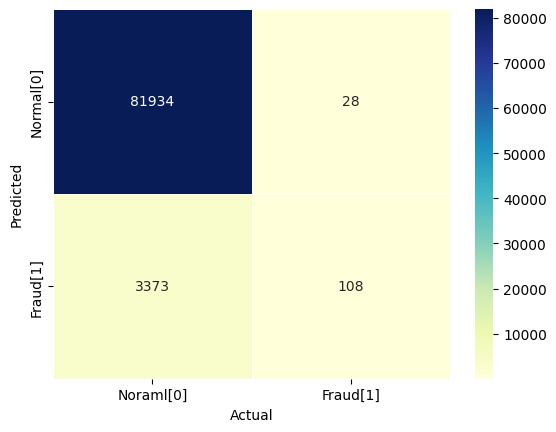

In [32]:
model_score = build_measure_performance(best_model, X_test, y_test, map_labels)

print("'precision', 'recall', 'f-score'")
print([ round(s,2) for s in model_score if s is not None]  )

performance_df = performance_df.append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)
performance_df

LOF (baseline) model


D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     81936
           1       0.46      0.02      0.03      3507

    accuracy                           0.96     85443
   macro avg       0.71      0.51      0.51     85443
weighted avg       0.94      0.96      0.94     85443

f1_score: 50.68%


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_9400\1096865992.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = performance_df.append({'model_name':model_name,


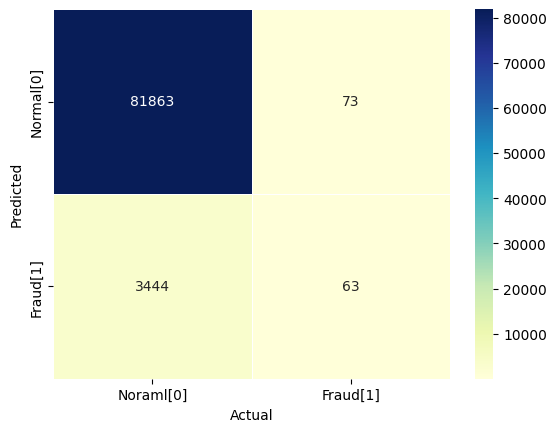

In [33]:
# Train a tuned local outlier factor model
model_lof = LocalOutlierFactor(n_neighbors=3, contamination=contamination_rate, novelty=True)
model_lof.fit(X_train)

# Evaluate model performance
model_name = 'LOF (baseline)'
print(f'{model_name} model')

map_labels = True 
model_score = build_measure_performance(model_lof, X_test, y_test, map_labels)
performance_df = performance_df.append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)



In [34]:
performance_df

,model_name,f1_score,precision,recall
0,Isolation Forest (baseline),0.901728,0.518367,0.526523
1,Isolation Forest (tuned),0.877289,0.515342,0.519693
2,Isolation Forest (tuned),0.877289,0.515342,0.519693
3,LOF (baseline),0.711432,0.508537,0.506779
